In [24]:
# Importando as bibliotecas para RNA
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Bibliotecas para acesso aos arquivos
import pandas as pd
import numpy as np

# Biblioteca para plotar o gráfico
import matplotlib.pyplot as plt

In [25]:
# Biblioteca com os parâmetros da RNA
arq = open('../datasets/mlp_param.txt')
args = arq.read()
args = eval(args)
#print(args)
arq.close()

In [26]:
# Verificando a possibilidade de executar na GPU (Cudas)
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [27]:
# Carregando os valores máximo e mínimo para normalização MIN-MAX
max_min = pd.read_csv('../datasets/min_max.csv', index_col=0)
max_min.head()

,cafe_do_mario,vo_mira_conilon,vo_mira_arabica,cafe_saulo_gourmet,cafe_saulo_especial,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,Acima de 2000,Abaixo de 2000
MAX,1.0,1.0,1.0,1.0,1.0,31.8,0.64,682.00073,224.500759,224.500759,1.0,1.0
MIN,0.0,0.0,0.0,0.0,0.0,26.0,0.49,0.00000,68.153180,119.391510,0.0,0.0


In [28]:
# Funções de Normalização
def minmax_norm(df_input, df_input_min, df_input_max):
    return(df_input - df_input_min) / (df_input_max - df_input_min)

def minmax_unorm(df_input, df_input_min, df_input_max):
    return (df_input * (df_input_max - df_input_min) + df_input_min)

In [29]:
# Implementando a MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, out_size):
        super(MLP, self).__init__()
        
        self.features = nn.Sequential(
                                nn.Linear(input_size, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, hidden_size2),
                                nn.ReLU(),
                               # nn.Linear(hidden_size2, hidden_size3),
                               # nn.ReLU(),
                        )
        self.out     = nn.Linear(hidden_size2, out_size)
    def forward(self, X):
        feature = self.features(X)
        output  = self.out(feature)
        return output

input_size  = 11 #Qtd de atributos de Entrada na RNA - MLP
hidden_size = args['size_shape']
hidden_size2 = args['size_shape2']
hidden_size3 = args['size_shape3']
out_size    = 1 # nº de variáveis preditas

net = MLP(input_size, hidden_size, hidden_size2, out_size).to(args['device']) # Se tiver GPU

# Carregando a RNA
net=torch.load('../datasets/net.pt', map_location=torch.device('cpu'))
print('Estrutura da RNA MLP:')
print(net.eval())

Estrutura da RNA MLP:
MLP(
  (features): Sequential(
    (0): Linear(in_features=11, out_features=138, bias=True)
    (1): ReLU()
    (2): Linear(in_features=138, out_features=46, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=46, out_features=1, bias=True)
)


In [33]:
dataset = pd.read_csv('../datasets/dataset_cafe_estatistica.csv',index_col=0)
list(dataset['grao'].unique())

['cafe_saulo_especial',
 'cafe_saulo_gourmet',
 'vo_mira_arabica',
 'vo_mira_conilon',
 'cafe_do_mario']

In [7]:
# Obtendo o intervalo de valores das categorias de grãos
print('Escolha a categoria do grao:')
print('1 - cafe_do_mario')
print('2 - vo_mira_conilon')
print('3 - vo_mira_arabica')
print('4 - cafe_saulo_gourmet')
print('5 - cafe_saulo_especial')
cat_grao = int(input('Categoria do grão: '))
if cat_grao == 1:
    filtro = 'cafe_do_mario'
elif cat_grao == 2:
    filtro = 'vo_mira_conilon'
elif cat_grao == 3:
    filtro = 'vo_mira_arabica'
elif cat_grao == 4:
    filtro = 'cafe_saulo_gourmet'
elif cat_grao == 5:
    filtro = 'cafe_saulo_especial'
# Intervalo válido de cada parâmetro
cont = dataset['grao'] == filtro
print()
print('# Intervalo válido de cada parâmetro #')
print(' - Temp. do Ambiente: [%.2f .. %.2f]' %(dataset[cont]['temp_amb'].min(), dataset[cont]['temp_amb'].max()))
print(' - Umid. do Ambiente: [%.2f .. %.2f]' %(dataset[cont]['umid_amb'].min(), dataset[cont]['umid_amb'].max()))
print(' - Temp. de Carga   : [%.2f .. %.2f]' %(dataset[cont]['charge_bt_modificado'].min(), \
                                               dataset[cont]['charge_bt_modificado'].max()))
print(' - Massa de Carga   : [%.2f .. %.2f]' %(dataset[cont]['massa_grao'].min(), dataset[cont]['massa_grao'].max()))
print(' - Tempo de Torra   : [%.2f .. %.2f]' %(dataset[cont]['timex'].min(), dataset[cont]['timex'].max()))

Escolha a categoria do grao:
1 - cafe_do_mario
2 - vo_mira_conilon
3 - vo_mira_arabica
4 - cafe_saulo_gourmet
5 - cafe_saulo_especial
Categoria do grão: 5

# Intervalo válido de cada parâmetro #
 - Temp. do Ambiente: [29.70 .. 31.70]
 - Umid. do Ambiente: [0.49 .. 0.64]
 - Temp. de Carga   : [190.68 .. 224.50]
 - Massa de Carga   : [1034.00 .. 2000.00]
 - Tempo de Torra   : [10.11 .. 587.97]


In [8]:
# Reecebendo os valores das features para gerar a saida
temp_amb = float(input('Valor da temperatuda ambiente: '))
umid_amb = float(input('Valor da umidade ambinte: '))
temp_car = float(input('Valor da temperatura de carga: '))
massa    = float(input('Massa de grãos: '))
#tempo_i  = float(input('Tempo de carga: '))
#tempo_i  = dataset[cont]['timex'].min()
tempo_i = 0
tempo_o  = float(input('Tempo de Torra: '))

Valor da temperatuda ambiente: 29.70
Valor da umidade ambinte: 0.49
Valor da temperatura de carga: 190.68
Massa de grãos: 1034
Tempo de Torra: 500


In [9]:
# Ajustando a categoria de grãos
cafe_do_mario       = 0
vo_mira_conilon     = 0
vo_mira_arabica     = 0
cafe_saulo_gourmet  = 0
cafe_saulo_especial = 0
if cat_grao == 1:
    cafe_do_mario = 1
elif cat_grao == 2:
    vo_mira_conilon = 1
elif cat_grao == 3:
    vo_mira_arabica = 1
elif cat_grao == 4:
    cafe_saulo_gourmet = 1
elif cat_grao == 5:
    cafe_saulo_especial = 1

# Ajustando a masa de grãos
acima_2000  = 0
abaixo_2000 = 0
if massa >= 2000:
    acima_2000  = 1
    abaixo_2000 = 0
else:
    acima_2000  = 0
    abaixo_2000 = 1
    
# Criando os pontos de tempo de torra
timex = list(range(int(tempo_i), int(tempo_o), 2))

In [10]:
# Montando o Dataframe
colunas = list(max_min.columns)
df_torra = pd.DataFrame(columns=colunas)
df_torra['timex'] = timex
df_torra['temp2'] = 0
df_torra['cafe_do_mario']   = cafe_do_mario
df_torra['vo_mira_conilon'] = vo_mira_conilon
df_torra['vo_mira_conilon'] = vo_mira_conilon
df_torra['vo_mira_arabica'] = vo_mira_arabica
df_torra['cafe_saulo_gourmet'] = cafe_saulo_gourmet
df_torra['cafe_saulo_especial'] = cafe_saulo_especial
df_torra['temp_amb'] = temp_amb
df_torra['umid_amb'] = umid_amb
df_torra['charge_bt_modificado'] = temp_car
df_torra['Acima de 2000'] = acima_2000
df_torra['Abaixo de 2000'] = abaixo_2000
df_torra.head()

,cafe_do_mario,vo_mira_conilon,vo_mira_arabica,cafe_saulo_gourmet,cafe_saulo_especial,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,Acima de 2000,Abaixo de 2000
0,0,0,0,0,1,29.7,0.49,0,0,190.68,0,1
1,0,0,0,0,1,29.7,0.49,2,0,190.68,0,1
2,0,0,0,0,1,29.7,0.49,4,0,190.68,0,1
3,0,0,0,0,1,29.7,0.49,6,0,190.68,0,1
4,0,0,0,0,1,29.7,0.49,8,0,190.68,0,1


In [11]:
# Normalizando o Dataframe
df_torra_norm = df_torra.copy()
for coluna in colunas:
    df_torra_norm[coluna] = minmax_norm(df_torra[coluna], max_min[coluna].loc['MIN'], max_min[coluna].loc['MAX'])

In [12]:
# Criando o nosso DataSet
class Dataset_amostras(Dataset):
    def __init__(self, df):
        self.dados = df.to_numpy()
        
    def __getitem__(self, idx):
        sample = self.dados[idx][[0,1,2,3,4,5,6,7,9,10,11]]
        label  = self.dados[idx][8:9]
        
        # Converter para Tensor
        sample = torch.from_numpy(sample.astype(np.float32))
        label  = torch.from_numpy(label.astype(np.float32))
        return sample, label
    
    def __len__(self):
        return len(self.dados)

In [13]:
test_set = Dataset_amostras(df_torra_norm)    
dado, rotulo = test_set[0]
print(rotulo)
print(dado)

tensor([-0.4359])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.6379, 0.0000, 0.0000, 0.6782,
        0.0000, 1.0000])


In [14]:
# Rodando os valores na RNA e gerando a predição
pred = []
for i in range(df_torra_norm.shape[0]):
    dado = test_set[i][0]
    pred.append(net(dado).cpu().data.numpy()[0])

In [15]:
# Incluindo os valores da predição no DataFrame normalizado 
# (Não precisa, mas já que existe...)
df_torra_norm['temp2'] = pred
df_torra['temp2'] = pred
df_torra_norm.head()

,cafe_do_mario,vo_mira_conilon,vo_mira_arabica,cafe_saulo_gourmet,cafe_saulo_especial,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,Acima de 2000,Abaixo de 2000
0,0.0,0.0,0.0,0.0,1.0,0.637931,0.0,0.000000,0.777553,0.678232,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.637931,0.0,0.002933,0.723096,0.678232,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.637931,0.0,0.005865,0.668638,0.678232,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.637931,0.0,0.008798,0.614180,0.678232,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.637931,0.0,0.011730,0.560059,0.678232,0.0,1.0


In [16]:
# "Desnormalizando" os valores
df_torra['temp2'] = minmax_unorm(df_torra['temp2'], max_min['temp2'].loc['MIN'], max_min['temp2'].loc['MAX'])
df_torra

,cafe_do_mario,vo_mira_conilon,vo_mira_arabica,cafe_saulo_gourmet,cafe_saulo_especial,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,Acima de 2000,Abaixo de 2000
0,0,0,0,0,1,29.7,0.49,0,189.721756,190.68,0,1
1,0,0,0,0,1,29.7,0.49,2,181.207428,190.68,0,1
2,0,0,0,0,1,29.7,0.49,4,172.693115,190.68,0,1
3,0,0,0,0,1,29.7,0.49,6,164.178757,190.68,0,1
4,0,0,0,0,1,29.7,0.49,8,155.717072,190.68,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,1,29.7,0.49,490,206.300735,190.68,0,1
246,0,0,0,0,1,29.7,0.49,492,206.548630,190.68,0,1
247,0,0,0,0,1,29.7,0.49,494,206.800003,190.68,0,1
248,0,0,0,0,1,29.7,0.49,496,207.051941,190.68,0,1


In [17]:
# Removendo os valores inicias até a temperatura de entrada dos grãos selecionada
for i in list(df_torra.index):
    if df_torra.loc[i, 'temp2'] > temp_car:
       df_torra.loc[i, 'temp2'] = temp_car
    else:
       break
df_torra.loc[0, 'temp2'] = temp_car
#df_torra

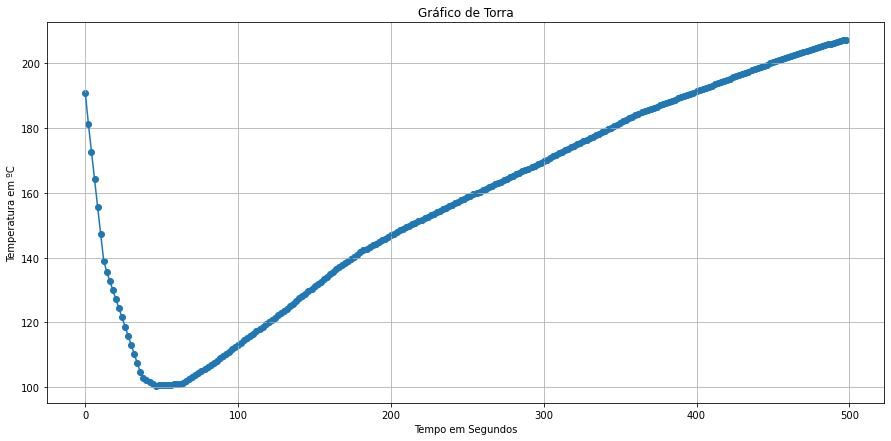

In [18]:
plt.rc('figure', figsize=(15,7))
plt.plot(df_torra['timex'], df_torra['temp2'])
plt.scatter(df_torra['timex'], df_torra['temp2'])
plt.title('Gráfico de Torra')
plt.xlabel('Tempo em Segundos')
plt.ylabel('Temperatura em ºC')
plt.grid()
plt.show()

In [19]:
# Lendo o arquivo exemplo RNA de torra
arq = '../datasets/saida_RNA.alog'
arq_torra = open(arq, 'r+')
torra = eval(arq_torra.read())

In [20]:
#print(torra)

In [21]:
torra['timex'] = list(df_torra['timex'].astype(float))
torra['temp2'] = list(df_torra['temp2'])
torra['temp1'] = list(df_torra['temp2'])
torra = str(torra)
#arq_torra.write(repr(torra))
#torra

In [22]:
torra1 = repr(torra)
torra1 = eval(torra1)
print(len(torra1))

35287


In [23]:
print(torra1)

{'version': '2.4.6', 'revision': '0', 'build': '0', 'artisan_os': 'Linux', 'artisan_os_version': 'glibc 2.27', 'mode': 'F', 'viewerMode': False, 'timeindex': [9, 0, 0, 0, 0, 0, 0, 0], 'flavors': [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0], 'flavorlabels': ['Acidez', 'Sensa\\xe7\\xe3o', 'X\\xedcara limpa', 'Impacto', 'Fragr\\xe2ncia', 'Do\\xe7ura', 'Aroma', 'Equil\\xedbrio', 'Corpo'], 'flavorstartangle': 90, 'flavoraspect': 1.0, 'title': 'Torrasc\\xf3pio', 'locale': 'pt', 'beans': '', 'weight': [0.0, 0.0, 'g'], 'volume': [0.0, 0.0, 'l'], 'density': [0.0, 'g', 1, 'l'], 'density_roasted': [0.0, 'g', 1, 'l'], 'roastertype': '', 'roastersize': 0.0, 'roasterheating': 0, 'machinesetup': '', 'operator': '', 'organization': '', 'drumspeed': '', 'heavyFC': False, 'lowFC': False, 'lightCut': False, 'darkCut': False, 'drops': False, 'oily': False, 'uneven': False, 'tipping': False, 'scorching': False, 'divots': False, 'whole_color': 0, 'ground_color': 0, 'color_system': '', 'volumeCalcWeightIn':